# Убедиться в нестабильности одиночного дерева на своих данных


In [5]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import pylab as plt
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingRegressor, BaggingClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
import statistics


Вводим данные

In [6]:
from IPython.core.pylabtools import figsize
figsize(10, 10) # зададим размер картинки
data = pd.read_csv('C:\\StudentsPerformance.csv', sep=',')

def math(mathscore):
    if mathscore >= 60:
        return 1
    return 0

data['math pass'] = data['math score'].apply(math)
data = data.drop(['math score'], axis='columns')
data = data.drop(['reading score'], axis='columns')
def ch(gender):
    if gender == 'male':
        return 1
    return 0

data['gender'] = data['gender'].apply(ch)

def cha(race):
    if race == 'group A':
        return 0
    if race == 'group B':
        return 1
    if race == 'group C':
        return 2
    if race == 'group D':
        return 3
    return 4

data['race/ethnicity'] = data['race/ethnicity'].apply(cha)

def chan(edu):
    if edu == 'some college':
        return 0
    if edu == "associate's degree":
        return 1
    if edu == 'high school':
        return 2
    if edu == 'some high school':
        return 3
    if edu == "bachelor's degree":
        return 4
    return 5

data['parental level of education'] = data['parental level of education'].apply(chan)

def chang(lunch):
    if lunch == 'standard':
        return 1
    return 0

data['lunch'] = data['lunch'].apply(chang)

def change(test):
    if test == 'completed':
        return 1
    return 0

data['test preparation course'] = data['test preparation course'].apply(change)

data1 = data.sort_values('writing score')

X = data[data.columns[:-1]]
y = data['math pass']

X1 = data1[data.columns[:-1]]
y1 = data1['math pass']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, stratify=y)

Напишем вспомогательную функцию, которая будет возвращать решетку для дальнейшей красивой визуализации.

In [7]:
def get_grid(data, eps=0.01):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, eps),
                         np.arange(y_min, y_max, eps))

Отобразим данные.

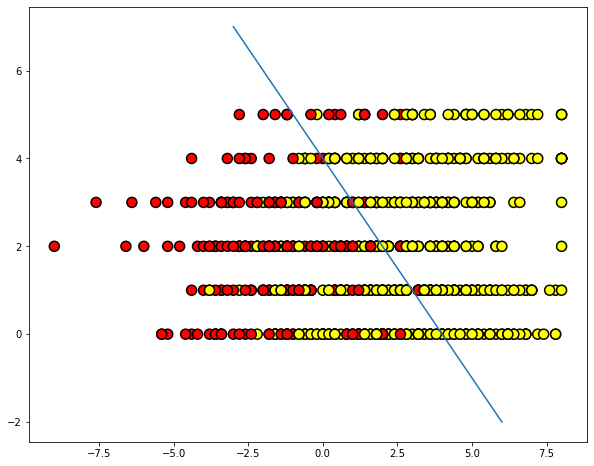

In [8]:
a=X_train["writing score"]/5-12
train_labels = y_train[0:750]
b=X_train["parental level of education"]
plt.rcParams['figure.figsize'] = (10,8)
plt.scatter(a, b, c=train_labels, s=100, 
            cmap='autumn', edgecolors='black', linewidth=1.5)
plt.plot(range(-3,7), range(7,-3,-1));

Обучим и построим дерево

In [9]:
from sklearn.tree import DecisionTreeClassifier
# параметр min_samples_leaf указывает, при каком минимальном количестве
# элементов в узле он будет дальше разделяться
clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=17)

# обучаем дерево
clf_tree.fit(X_train, train_labels)
clf_tree.score(X_train, train_labels)
# немного кода для отображения разделяющей поверхности


0.8853333333333333

In [10]:
# используем .dot формат для визуализации дерева
from ipywidgets import Image
from io import StringIO
import pydotplus
from sklearn.tree import export_graphviz

dot_data = StringIO()
export_graphviz(clf_tree, feature_names=['x1', 'x2','x3', 'x4','x5', 'x6',], 
                out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(value=graph.create_png())

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03\xd8\x00\x00\x01\xf1\x08\x02\x00\x00\x00\x19t\x83…

Теперь построим дерево с отсортированными данными

In [11]:
train_labels1 = y1_train[0:750]
clf_tree1 = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=17)

# обучаем дерево
clf_tree1.fit(X1_train, train_labels1)
clf_tree1.score(X1_train, train_labels1)


0.8906666666666667

In [12]:
dot_data = StringIO()
export_graphviz(clf_tree1, feature_names=['x1', 'x2','x3', 'x4','x5', 'x6',], 
                out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(value=graph.create_png())

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03\xd4\x00\x00\x01\xf1\x08\x02\x00\x00\x00\x03Hc\x7…

<!-- 
export_graphviz(clf_tree, feature_names=['x1', 'x2'], 
                out_file='../../img/small_tree.dot', filled=True)
!dot -Tpng '../../img/small_tree.dot' -o '../../img/small_tree.png'

<img src='../../img/small_tree.png'> -->

### Как дерево решений работает с количественными признаками

Допустим, в выборке имеется количественный признак "Возраст", имеющий много уникальных значений. Дерево решений будет искать лучшее (по критерию типа прироста информации) разбиение выборки, проверяя бинарные признаки типа "Возраст < 17", "Возраст < 22.87" и т.д. Но что если таких "нарезаний" возраста слишком много? А что если есть еще количественный признак "Зарплата", и зарплату тоже можно "нарезать" большим числом способов? Получается слишком много бинарных признаков для выбора лучшего на каждом шаге построения дерева. Для решения этой проблемы применяют эвристики для ограничения числа порогов, с которыми мы сравниваем количественный признак. 

Рассмотрим это на игрушечном примере. Пусть есть следующая выборка:

1	writing score       	0.653794
2	parental level of education	0.088146
3	gender              	0.086950
4	race/ethnicity      	0.083080
5	lunch               	0.055501
6	test preparation course	0.032529


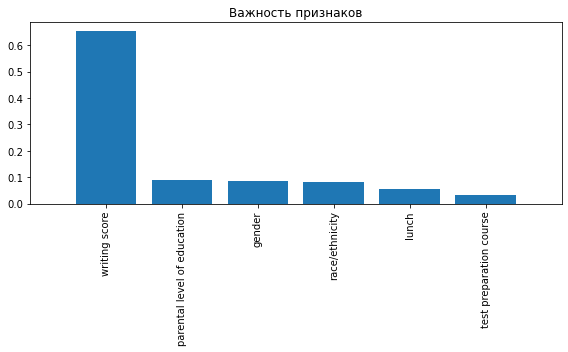

In [13]:
plt.rcParams['figure.figsize'] = (8,5)

from sklearn.ensemble import RandomForestClassifier
feat_labels = data.columns[0:6]

forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print( "{}\t{: <20}\t{:.6f}".format(f+1, feat_labels[indices[f]], importances[indices[f]]) )
    
plt.title("Важность признаков")
plt.bar( range(X_train.shape[1]), importances[indices], align='center' )
plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation=90);

plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

In [14]:
labelencoder=LabelEncoder()
for col in data.columns:
    mean = statistics.mean(data[col].dropna())
    
    data[col] = data[col].apply(lambda value: mean if pd.isnull(value) else value)
X = np.array(data[['writing score','parental level of education']])

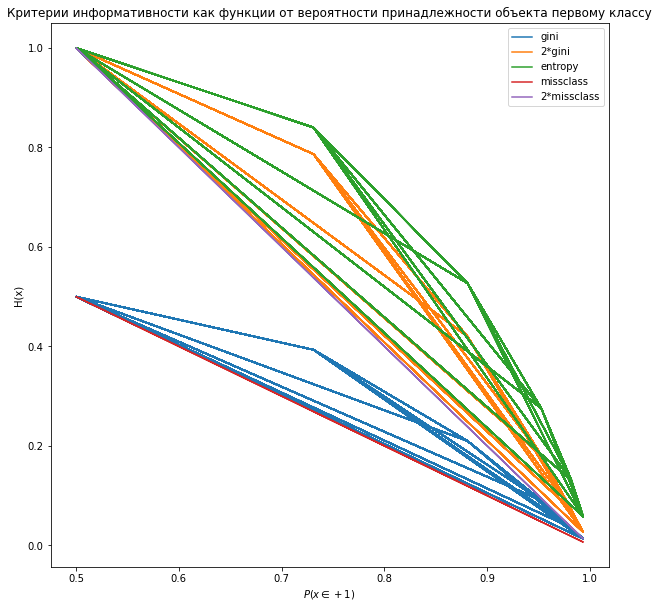

In [15]:
import math
plt.rcParams['figure.figsize'] = (10,10)

b = [ 1 / (1 + math.exp(-x)) for x in b]

plt.plot(b, [2 * x * (1-x) for x in b], label='gini')
plt.plot(b, [4 * x * (1-x) for x in b], label='2*gini')
plt.plot(b, [-x * np.log2(x) - (1-x) * np.log2(1 - x)  for x in b], label='entropy')
plt.plot(b, [1 - max(x, 1-x) for x in b], label='missclass')
plt.plot(b, [2 - 2 * max(x, 1-x) for x in b], label='2*missclass')

plt.xlabel('$P(x \in +1)$')
plt.ylabel('H(x)')
plt.title('Критерии информативности как функции от вероятности принадлежности объекта первому классу')
plt.legend();

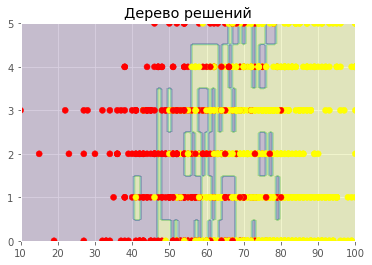

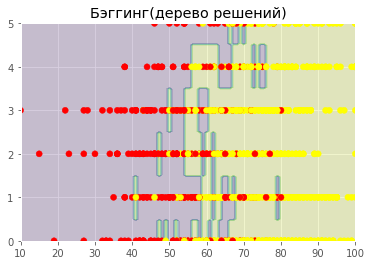

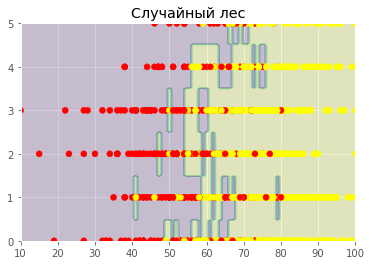

In [16]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 6
%matplotlib inline

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train, y_train)

x1_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
x2_range = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
xx1, xx2 = np.meshgrid(x1_range, x2_range)
y_hat = dtree.predict(np.c_[xx1.ravel(), xx2.ravel(), ])
y_hat = y_hat.reshape(xx1.shape)
plt.contourf(xx1, xx2, y_hat, alpha=0.2)
plt.scatter(X[:,0], X[:,1], c=y, cmap='autumn')
plt.title("Дерево решений")
plt.show()

b_dtree = BaggingClassifier(DecisionTreeClassifier(), n_estimators=300, random_state=42)
b_dtree.fit(X_train, y_train)

x1_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
x2_range = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
xx1, xx2 = np.meshgrid(x1_range, x2_range)
y_hat = b_dtree.predict(np.c_[xx1.ravel(), xx2.ravel()])
y_hat = y_hat.reshape(xx1.shape)
plt.contourf(xx1, xx2, y_hat, alpha=0.2)
plt.scatter(X[:,0], X[:,1], c=y, cmap='autumn')
plt.title("Бэггинг(дерево решений)")
plt.show()

rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

x1_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
x2_range = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
xx1, xx2 = np.meshgrid(x1_range, x2_range)
y_hat = rf.predict(np.c_[xx1.ravel(), xx2.ravel()])
y_hat = y_hat.reshape(xx1.shape)
plt.contourf(xx1, xx2, y_hat, alpha=0.2)
plt.scatter(X[:,0], X[:,1], c=y, cmap='autumn')
plt.title("Случайный лес")
plt.show()

# Сравнить качество работы случайного леса без кросс валидации с кросс-валидацией

0.776


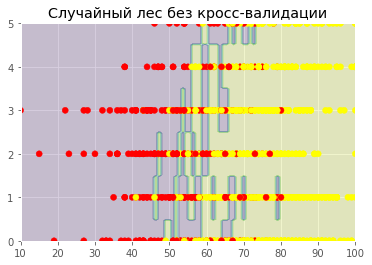

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

x1_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
x2_range = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
xx1, xx2 = np.meshgrid(x1_range, x2_range)
y_hat = rf.predict(np.c_[xx1.ravel(), xx2.ravel()])
y_hat = y_hat.reshape(xx1.shape)
print(rf.score(X_test, y_test))
plt.contourf(xx1, xx2, y_hat, alpha=0.2)
plt.scatter(X[:,0], X[:,1], c=y, cmap='autumn')
plt.title("Случайный лес без кросс-валидации")
plt.show()

TRAIN: [200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235
 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253
 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271
 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289
 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307
 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325
 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343
 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361
 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379
 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397
 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414 415
 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430 431 432 433
 434 435 436 437 438 439 440 441 442 443 444

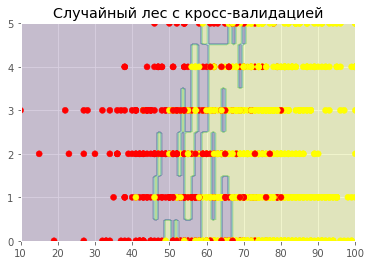

In [18]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
rf = RandomForestClassifier(n_estimators=300, random_state=42)
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    rf.fit(X[train_index,:], y[train_index])
    print(rf.score(X[test_index,:], y[test_index]))
print(rf.score(X, y))



x1_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
x2_range = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
xx1, xx2 = np.meshgrid(x1_range, x2_range)
y_hat = rf.predict(np.c_[xx1.ravel(), xx2.ravel()])
y_hat = y_hat.reshape(xx1.shape)
plt.contourf(xx1, xx2, y_hat, alpha=0.2)
plt.scatter(X[:,0], X[:,1], c=y, cmap='autumn')
plt.title("Случайный лес с кросс-валидацией")
plt.show()

# Сравнить качество работы и время обучения (%%time в начале ячейки) леса с градиентным бустингом над решающими деревьями, при подобрав для каждого оптимальные параметры.

In [19]:
%%time

from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
import numpy as np

scores = np.ndarray([10, 10])
for i, n_trees in enumerate(np.linspace(1, 100, 10)):
    for j, depth in enumerate(np.arange(2, 12)):
        p = CatBoostRegressor(n_estimators=n_trees, max_depth=depth, task_type="GPU").fit(X_train, y_train).predict(X_test)
        scores[i, j] = mean_squared_error(y_test, p)

Learning rate set to 0.5
0:	learn: 0.3933421	total: 12.8ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3873531	total: 3.57ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3868040	total: 4.08ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3870720	total: 4.6ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3879431	total: 5.03ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3856292	total: 5.57ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3847231	total: 6.79ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3850222	total: 6.99ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3861220	total: 8.28ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3861220	total: 9.63ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3933421	total: 3.7ms	remaining: 40.7ms
1:	learn: 0.3644946	total: 6.67ms	remaining: 33.4ms
2:	learn: 0.3544419	total: 9.63ms	remaining: 28.9ms
3:	learn: 0.3516825	total: 12.6ms	remaining: 25.2ms
4:	learn: 0.3500041	total: 15

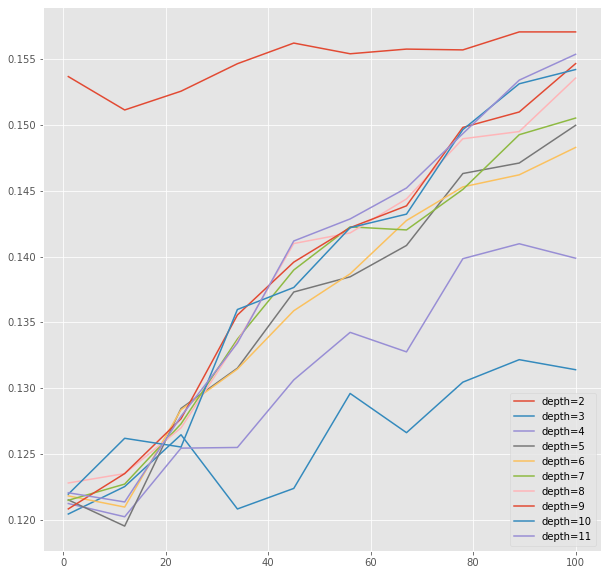

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
plt.figure(figsize=(10,10))
for i in range(scores.shape[0]):
    plt.plot(np.linspace(1, 100, 10), scores[i], label='depth=' + str(np.arange(2, 12)[i]))
plt.legend()

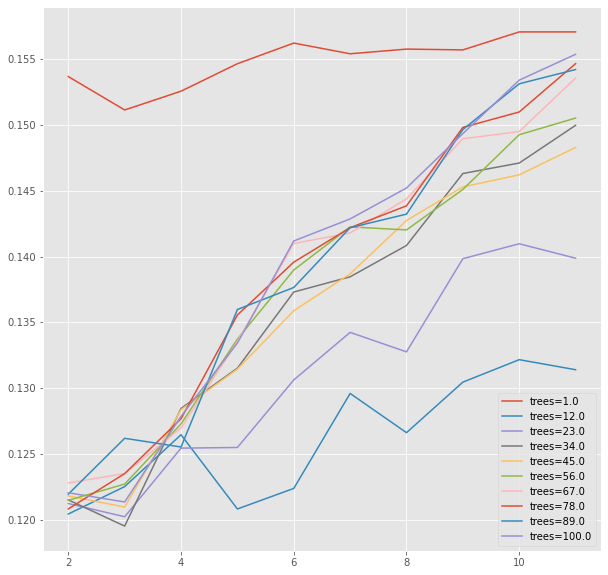

In [22]:
plt.figure(figsize=(10,10))
for i in range(scores.shape[1]):
    plt.plot(np.arange(2, 12), scores[i], label='trees=' + str(np.linspace(1, 100, 10)[i]))
plt.legend()

In [23]:
%%time

from sklearn.ensemble import RandomForestRegressor

linear_preds = RandomForestRegressor().fit(X_train, y_train).predict(X_test)
res5 = mean_squared_error(y_test, linear_preds) ** 0.5
print(res5)

0.3919948671772422
Wall time: 108 ms
